In [1]:
import os
import sys
import time
import traceback
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd

import shutil
import mne
import keras
from ecgdetectors import Detectors

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D , Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

warnings.filterwarnings('ignore')

2023-10-07 16:10:22.056341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-07 16:10:22.074675: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 16:10:22.167678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 16:10:22.168246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 16:10:22.848138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
# constants/Global variables
#
Hz = 64 
CACHE_DB = {}
RR_SIG_DIM = 1920
N_CHAN = 1
DATA_DIR = "data/cap-sleep-database-1.0.0/np_data_64"
LOG_DIR = "logs"
MODEL_DIR = "models"

CLASS_MAP = {  # Sleep-Wake
    "S0": 0,
    "S1": 1,
    "S2": 1,
    "S3": 1,
    "S4": 1,
    "REM": 1,
}
# CLASS_MAP = {  # REM-NREM Sleep
#     "S1": 0,
#     "S2": 0,
#     "S3": 0,
#     "S4": 0,
#     "REM": 1,
# }
# CLASS_MAP = {  # LS-DS sleep
#     "S1": 0,
#     "S2": 0,
#     "S3": 1,
#     "S4": 1,
# }


N_CLASSES = len(set(CLASS_MAP.values()))
RR_MIN, RR_MAX = 0.2, 1.0

# instances
ECG_DETECTOR = Detectors(Hz)
# minmax_scaler = MinMaxScaler()

In [3]:
def get_rr_signal(y, hz, target_n_samp, rr_min=0.3, rr_max=1.0, log=print):
    r_peaks = ECG_DETECTOR.pan_tompkins_detector(y)
    rr_signal = np.diff(r_peaks) / hz  # normalise for 0-1 range
    rr_signal = rr_signal[(rr_signal >= rr_min) & (rr_signal <= rr_max)]  # ignore < 0.5
    rr_signal = signal.resample(rr_signal, target_n_samp) if rr_signal.shape[0]>5 else None
    return rr_signal


def get_class_weights(labels, n_class=2, log=print):
    freq = np.zeros(n_class)
    for label in labels:
        freq[label] += 1
    # w = freq / sum(freq)
    w = sum(freq) / freq
    log(f"--get_class_weights, freq:{freq}, w:{w}")
    return freq, w


In [4]:
class EcgRRParentDB():
    def __init__(
            self, np_data_dir, list_rec_names=None, batch_sz=32, hz=64, n_channels=1, shuffle=False, log=print,
            rr_sig_dim=100, n_history_seg=0,
            class_map={
                "S0": 0,
                "S1": 1,
                "S2": 1,
                "S3": 1,
                "S4": 1,
                "REM": 1,
            }
    ):
        self.np_data_dir = np_data_dir
        self.list_rec_names = list_rec_names
        self.batch_sz = batch_sz
        self.hz = hz
        self.class_map = class_map
        self.n_classes = len(set(class_map.values()))
        self.sig_dim = self.hz * 30  # 30 sec @64Hz
        self.rr_sig_dim = rr_sig_dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.log = log
        self.n_history_seg = n_history_seg
        self.samples_meta = []
        # self.cached_data=CACHE_DB
        self.record_names = []
        self.subject_wise_samples = {}

        self._init_data_dict()

    def _init_data_dict(self):
        self.log("Initialise meta data of samples")
        reached_sleep_stage_line = False
        for f in os.listdir(self.np_data_dir):
            reached_sleep_stage_line = False
            seg_count = 0
            if not f.endswith(".csv"):
                continue
            rec_name = f[:-4]
            if not rec_name in self.list_rec_names:
                continue            
            
            self.log(f"Loading {rec_name}...")
            self.record_names.append(rec_name)
            if self.subject_wise_samples.get(rec_name) is None:
                    self.subject_wise_samples[rec_name] = []

            sig_filepath = f"{self.np_data_dir}/{f}"
            ecg_sig = np.loadtxt(sig_filepath, delimiter=",")
            annot_filepath = sig_filepath.replace('.csv', '.txt')
            with open(annot_filepath, "r") as f:
                lines = f.readlines()
            n_seg_est = ecg_sig.shape[0]//self.sig_dim    
            self.log(f"[{rec_name}] {ecg_sig.shape}, n_seg:{n_seg_est}")
            start = 0
            ignored_annots_bad_len, ignored_annots_bad_label = 0, 0
            self.log(f"recording:{ecg_sig.shape}")
            for line in lines:
                # print(line)
                tokens = line.split("\t")
                if not reached_sleep_stage_line and not line.startswith("Sleep Stage"):
                    continue
                if line.startswith("Sleep Stage"):
                    reached_sleep_stage_line = True
                    continue
                # Annotation starts
                try:
                    tok_is_sleep = tokens[-3]
                    if tok_is_sleep.find("SLEEP-") < 0:
                        current_epoch_len = int(tokens[-2])
                        continue
                    label_str = tok_is_sleep.split("-")[-1]
                    label = self.class_map.get(label_str)
                    current_epoch_len = int(tokens[-2])
                except:
                    self.log(f"--> error parsing epoch-len: {tokens[-2]}")
                    ignored_annots_bad_len += 1
                    continue
                if current_epoch_len != 30:  # not a valid sleep epoch
                    ignored_annots_bad_len += 1
                    self.log(f"--> bad length: {current_epoch_len}")
                    # start += (current_epoch_len*self.hz)
                    continue
                if label is None:
                    # self.log(
                    #     f"Ignored label for label_str:{label_str}->{label} >> {line}")
                    ignored_annots_bad_label += 1
                    start += self.sig_dim
                    continue
                end = start + self.sig_dim
                seg = ecg_sig[start : end]
                remaining = len(ecg_sig) - end

                if len(seg) != self.sig_dim:
                    self.log(f"bad seg_sz:{len(seg)} >> {line}")
                    start += self.sig_dim
                    continue

                # Generate RR signal, ignore segment with poor signal quality
                # self.log(f"input seg: {len(seg)}, seg_count:{seg_count}")
                rr_sig = get_rr_signal(seg, Hz, target_n_samp=self.rr_sig_dim, rr_min=RR_MIN, rr_max=RR_MAX)
                if rr_sig is None:
                    # self.log(f"RR with less than {RR_MIN} R-peaks")
                    start += self.sig_dim
                    continue

                # store segment and RR signal, we can use either of them or both in the  model.
                # 
                self.samples_meta.append((rec_name, zscore(seg), rr_sig, label))
                
                # Maintain a list of segments for each subject
                # 
                self.subject_wise_samples[rec_name].append(len(self.samples_meta)-1)

                # update start
                start += self.sig_dim
                seg_count += 1    

            self.log(
                f"...[{rec_name}], n_seg:{seg_count} out of {n_seg_est} (lags seg:{n_seg_est-seg_count}, "
                f"samples:{(n_seg_est-seg_count)*self.sig_dim}), bad_label: {ignored_annots_bad_label}, bad_len/ignored: {ignored_annots_bad_len}, "
                f"remaining:{remaining}"
                )
        self.log(f"Total sample-meta loaded: {len(self.samples_meta)}")
        self.indexes = list(range(len(self.samples_meta)))
        np.random.shuffle(self.indexes)
        self.log(f"Record names: {self.record_names}")
        for rec_name in self.record_names:
            values, counts = np.unique([self.samples_meta[i][-1] for i in self.subject_wise_samples[rec_name]], return_counts=True)
            self.log(f"[{rec_name}] n_samples:{len(self.subject_wise_samples[rec_name])}, values:{values}, counts:{counts}")

In [7]:
class PartialGenerator(keras.utils.Sequence):
    def __init__(
            self, parent_db, indexes, batch_sz=None, is_raw_ecg=True
    ):
        self.parent_db = parent_db
        self.indexes = indexes
        self.batch_sz = batch_sz if batch_sz is not None else self.parent_db.batch_sz
        self.is_raw_ecg = is_raw_ecg
    
    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_sz))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_sz:(idx+1)*self.batch_sz]
        X, y = self.__data_generation(batch_indexes)
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Choice, ECG signal or RR signal? 
        # 
        if self.is_raw_ecg:
            seg_dim = self.parent_db.sig_dim
        else:
            seg_dim = self.parent_db.rr_sig_dim

        X = np.empty((self.batch_sz, seg_dim, self.parent_db.n_channels))
        y = np.empty((self.batch_sz), dtype=int)

        # Generate data, retrieve from files
        for i, ID in enumerate(list_IDs_temp):
            _, segment, rr_sig, label = self.parent_db.samples_meta[ID]
            y[i] = label
            if self.is_raw_ecg:
                # ECG signal
                X[i,] = segment.reshape((seg_dim, 1))
            else:
                # R-R signal
                X[i,] = rr_sig.reshape((seg_dim, 1))
            y[i] = label
        return X, keras.utils.to_categorical(y, num_classes=self.parent_db.n_classes)

Initialise meta data of samples
Loading n1...
[n1] (2202240,), n_seg:1147
recording:(2202240,)
...[n1], n_seg:1140 out of 1147 (lags seg:7, samples:13440), bad_label: 0, bad_len/ignored: 0, remaining:13440
Total sample-meta loaded: 1140
Record names: ['n1']
[n1] n_samples:1140, values:[0 1], counts:[  39 1101]
(1, 1920, 1) [[0. 1.]]


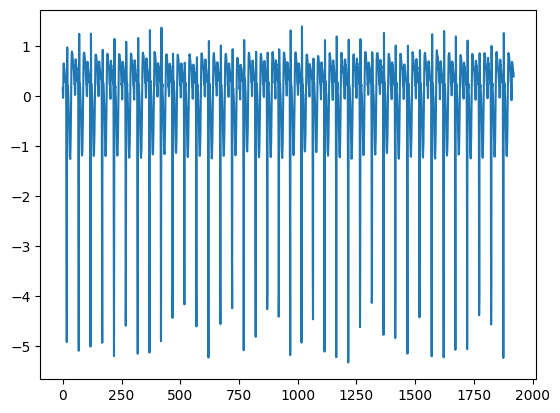

(1, 1920, 1) [[0. 1.]]


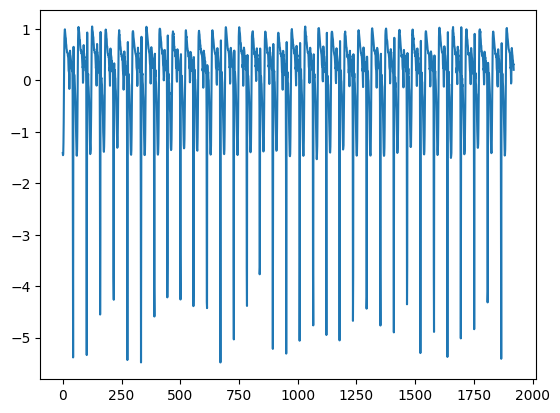

(1, 1920, 1) [[0. 1.]]


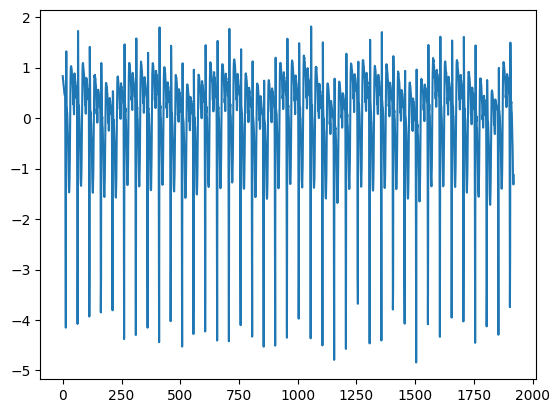

(1, 1920, 1) [[0. 1.]]


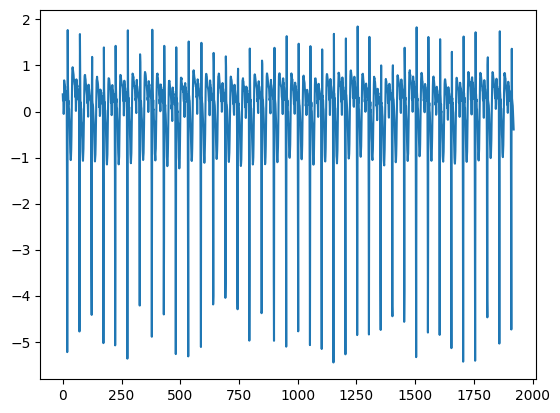

(1, 1920, 1) [[0. 1.]]


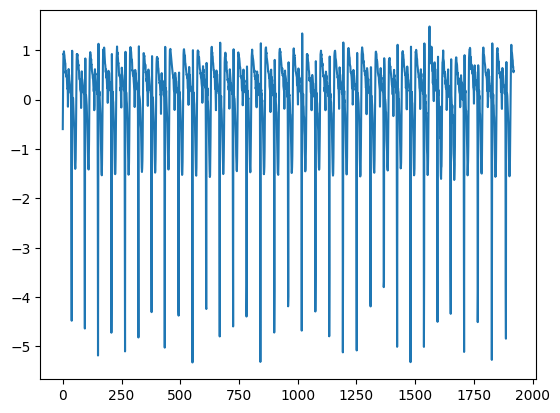

In [14]:
# Test data generator
# 
mem_db = EcgRRParentDB(
    DATA_DIR, list_rec_names=["n1"], n_history_seg=2, rr_sig_dim=RR_SIG_DIM, class_map=CLASS_MAP)
gen = PartialGenerator(mem_db, mem_db.indexes, batch_sz=1, is_raw_ecg=True)
# gen = PartialGenerator(mem_db, mem_db.indexes, batch_sz=1, is_raw_ecg=False)
for i in range(5):
    x, y = gen[i]
    print(x.shape, y)
    seg = x[0, :, 0]
    plt.plot(range(len(seg)), seg)
    # plt.ylim((0, 1))
    plt.show()


In [11]:
def get_model_1():
    input_layer = keras.layers.Input((RR_SIG_DIM, N_CHAN))

    print(f"input layer: {input_layer.shape}")

    cnn1 = Conv1D(filters=8, kernel_size=(11), strides=(1), groups=N_CHAN, activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", dilation_rate=1)(input_layer)
    cnn1 = MaxPool1D(pool_size=(2), strides=(2))(cnn1)
    cnn1 = Conv1D(filters=8, kernel_size=(11), strides=(1), groups=N_CHAN, activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", dilation_rate=1)(cnn1)
    cnn1 = MaxPool1D(pool_size=(2), strides=(2))(cnn1)
    cnn1 = Conv1D(filters=8, kernel_size=(7), strides=(1), groups=N_CHAN, activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", dilation_rate=1)(cnn1)
    cnn1 = MaxPool1D(pool_size=(2), strides=(2))(cnn1)
    cnn1 = Conv1D(filters=8, kernel_size=(7), strides=(1), groups=N_CHAN, activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", dilation_rate=1)(cnn1)
    cnn1 = MaxPool1D(pool_size=(2), strides=(2))(cnn1)
    cnn1 = Conv1D(filters=8, kernel_size=(7), strides=(1), groups=N_CHAN, activation=keras.layers.LeakyReLU(alpha=0.01), padding="same", dilation_rate=1)(cnn1)
    cnn1 = MaxPool1D(pool_size=(2), strides=(2))(cnn1)

    cnn1 = Flatten()(cnn1)

    fc = Dense(units=128, activation="relu")(cnn1)
    fc = Dense(units=64, activation="relu")(fc)
    output_layer = Dense(units=N_CLASSES, activation="softmax")(fc)

    print(f"output_layer: {output_layer.shape}")
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = get_model_1()
model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
X = np.random.rand(32, RR_SIG_DIM, N_CHAN)
y_pred = model(X)
print(y_pred.shape)

input layer: (None, 1920, 1)
output_layer: (None, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1920, 8)           96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 960, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 960, 8)            712       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 480, 8)           0         
 1D)                                                             
                                                                 
 conv1d_

In [12]:
# names = ["n1", "n2", "n3","n5", "n6", "n7","n9", "n10", "n11","n13", "n14"]
names = [f"n{i}" for i in range(1, 20)]
# names = [f"ins{i}" for i in range(1, 10)]    
mem_db = EcgRRParentDB(
    DATA_DIR, list_rec_names=names, class_map=CLASS_MAP, rr_sig_dim=RR_SIG_DIM, n_channels=N_CHAN)

Initialise meta data of samples
Loading n13...
[n13] (1944520,), n_seg:1012
recording:(1944520,)
...[n13], n_seg:938 out of 1012 (lags seg:74, samples:142080), bad_label: 0, bad_len/ignored: 0, remaining:116680
Loading n11...
[n11] (2021760,), n_seg:1053
recording:(2021760,)
...[n11], n_seg:1049 out of 1053 (lags seg:4, samples:7680), bad_label: 0, bad_len/ignored: 0, remaining:3840
Loading n14...
[n14] (1947026,), n_seg:1014
recording:(1947026,)
...[n14], n_seg:965 out of 1014 (lags seg:49, samples:94080), bad_label: 0, bad_len/ignored: 0, remaining:94226
Loading n10...
[n10] (1651200,), n_seg:860
recording:(1651200,)
...[n10], n_seg:852 out of 860 (lags seg:8, samples:15360), bad_label: 0, bad_len/ignored: 0, remaining:15360
Loading n2...
[n2] (2104320,), n_seg:1096
recording:(2104320,)
...[n2], n_seg:867 out of 1096 (lags seg:229, samples:439680), bad_label: 0, bad_len/ignored: 0, remaining:186240
Loading n1...
[n1] (2202240,), n_seg:1147
recording:(2202240,)
...[n1], n_seg:1140 out

In [13]:


np_data_dir=DATA_DIR

def leave_ones():    
    # metrics_df = pd.DataFrame(
    #     columns=[
    #         'validation_sub', 
    #         'loss', 
    #         'accuracy', 
    #         'val_loss', 
    #         'val_accuracy', 
    #         'time_per_epoch'
    #     ])


    for i_test_rec in range(len(mem_db.record_names)):
        test_rec_name = mem_db.record_names[i_test_rec]
        train_rec_names = mem_db.record_names[i_test_rec+1:] + mem_db.record_names[:i_test_rec]  

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
        idx_train_samples = []
        for train_rec_name in train_rec_names:
            idx_train_samples.extend(mem_db.subject_wise_samples[train_rec_name])

        # extract label to do skf for train/validation split
        # 
        train_idx, val_idx = next(
            skf.split(
                np.zeros((len(idx_train_samples), 1)),  # dummy train sample
                [mem_db.samples_meta[ID][-1] for ID in idx_train_samples])
        )
        # translate skf indexes back in terms of idx_train_samples
        train_idx = [idx_train_samples[i] for i in train_idx]
        val_idx = [idx_train_samples[i] for i in val_idx]
        train_generator = PartialGenerator(mem_db, train_idx)
        val_generator = PartialGenerator(mem_db, val_idx)
        test_generator = PartialGenerator(mem_db, mem_db.subject_wise_samples[test_rec_name], batch_sz=1)

        train_labels_ = [mem_db.samples_meta[i][-1] for i in train_idx]
        # weight_0, weight_1 = get_class_weights(train_labels_)[-1]
        clz_weights = {}
        for i, w in enumerate(get_class_weights(train_labels_, n_class=N_CLASSES)[-1]):
            clz_weights[i] = w
        print(f"Class weights: {clz_weights}")
        
        model= get_model_1()

        # Compile the model with the computed class weights
        model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  
        # fit the model
        start_time = time.time()
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                f"{MODEL_DIR}/{test_rec_name}_vgg16RR_V2_1.h5", monitor='val_loss', verbose=1, 
                save_best_only=True, save_weights_only=False, mode='auto', period=1),
            
            keras.callbacks.EarlyStopping(
                monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto'),
            
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001),
            
            keras.callbacks.CSVLogger(
                f"{LOG_DIR}/{test_rec_name}_training.csv", separator=",", append=False),
        ]
        
        hist = model.fit(
            # steps_per_epoch=7, 
            x=train_generator,
            y=None,
            validation_data=val_generator,
            class_weight=clz_weights,
            # validation_steps=10, 
            epochs=70,
            callbacks=callbacks,
            verbose=1)
        
        end_time = time.time()
    
        iteration_name = f"Subject-{test_rec_name}"
        hist_df = pd.DataFrame(hist.history)
        hist_df['validation_sub'] = iteration_name
        
        time_per_epoch = (end_time - start_time) / len(hist.history['loss'])
        hist_df['time_per_epoch'] = time_per_epoch
        
        # metrics_df = metrics_df.append(hist_df, ignore_index=True)
        # metrics_df = pd.concat([metrics_df, hist_df]).sample(frac=1).reset_index(drop=True)
        
        # Save the metrics DataFrame to Excel after each iteration (epoch)
        # metrics_df.to_csv(f'{LOG_DIR}/metricsRRV2_1.csv', index=False)
        
        # Load the trained model from the saved .h5 file
        model_val = load_model(f"{MODEL_DIR}/{test_rec_name}_vgg16RR_V2_1.h5")
        
        # Make predictions on the validation data using the loaded model
        predictions = model_val.predict_generator(test_generator)
        
        # Get the actual labels from the generator
        actual_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
        
        # Create a DataFrame to store the actual and predicted values
        dict_pred = {'labels': np.argmax(actual_labels, axis=1) , 'preds': np.argmax(predictions, axis=1),}
        for i_clz in range(N_CLASSES):
            dict_pred.update({f'class_{i_clz}':predictions[:, i_clz]})
        prediction_df = pd.DataFrame(dict_pred)
        # prediction_df = pd.DataFrame({'Label': np.argmax(actual_labels, axis=1) ,
        #                               'Preds': np.argmax(predictions, axis=1),
        #                               'Class_0': predictions[:, 0],'Class_1': predictions[:, 1] })
        
        # Save the DataFrame to a CSV file with the subject name
        prediction_df.to_csv(f'{LOG_DIR}/{test_rec_name}_predictions.csv', index=False)

# main entry
# 
leave_ones()

--get_class_weights, freq:[ 641. 6147.], w:[10.58970359  1.10427851]
Class weights: {0: 10.589703588143525, 1: 1.1042785098421994}
input layer: (None, 1920, 1)
output_layer: (None, 2)
Epoch 1/70


2023-10-07 16:52:40.342475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


204/212 [===========================>..] - ETA: 0s - loss: 1.5072 - accuracy: 0.8309

2023-10-07 16:52:42.668691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.73791, saving model to models/n13_vgg16RR_V2_1.h5
212/212 [==============================] - 3s 8ms/step - loss: 1.5138 - accuracy: 0.8042 - val_loss: 0.7379 - val_accuracy: 0.0943 - lr: 0.0010
Epoch 2/70
209/212 [============================>.] - ETA: 0s - loss: 1.2048 - accuracy: 0.6778
Epoch 2: val_loss improved from 0.73791 to 0.62041, saving model to models/n13_vgg16RR_V2_1.h5
212/212 [==============================] - 2s 7ms/step - loss: 1.1994 - accuracy: 0.6792 - val_loss: 0.6204 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/70
211/212 [============================>.] - ETA: 0s - loss: 1.0273 - accuracy: 0.8827
Epoch 3: val_loss improved from 0.62041 to 0.43182, saving model to models/n13_vgg16RR_V2_1.h5
212/212 [==============================] - 2s 7ms/step - loss: 1.0245 - accuracy: 0.8833 - val_loss: 0.4318 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 4/70
207/212 [============================>.] - ETA: 0s - loss: 0.9758 - accuracy: 0.880

2023-10-07 16:53:24.410625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


--get_class_weights, freq:[ 750. 5950.], w:[8.93333333 1.12605042]
Class weights: {0: 8.933333333333334, 1: 1.1260504201680672}
input layer: (None, 1920, 1)
output_layer: (None, 2)
Epoch 1/70


2023-10-07 16:53:25.798540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


209/209 [==============================] - ETA: 0s - loss: 1.3882 - accuracy: 0.3361

2023-10-07 16:53:28.472263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.67861, saving model to models/n11_vgg16RR_V2_1.h5
209/209 [==============================] - 3s 10ms/step - loss: 1.3882 - accuracy: 0.3361 - val_loss: 0.6786 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 2/70
208/209 [============================>.] - ETA: 0s - loss: 1.2064 - accuracy: 0.7447

KeyboardInterrupt: 